In [275]:
# initial setup
try:
    # settings colab:
    import google.colab
    
except ModuleNotFoundError:    
    # settings local:
    %run "common/0_notebooks_base_setup.py"

default checking
Running command `conda list`... ok
jupyterlab=1.2.6 already installed
pandas=1.0.3 already installed
matplotlib=2.2.2 already installed
bokeh=2.0.0 already installed
seaborn=0.10.0 already installed
ipywidgets=7.5.1 already installed
pytest=5.3.4 already installed
chardet=3.0.4 already installed
psutil=5.7.0 already installed
scipy=1.4.1 already installed
statsmodels=0.11.0 already installed
scikit-learn=0.22.1 already installed
xlrd=1.2.0 already installed
nltk=3.4.5 already installed
unidecode=1.0.23 already installed
pydotplus=2.0.2 already installed


<Figure size 432x288 with 0 Axes>

<h1>Desafio 3 - Grupo 5</h1>

<h3><u>Intregrantes del grupo</u></h3>

- Juan Pablo Ferrari
- Alejandro Jait
- Miriam Lanabere
- Panizza, Camila    

<h3><u>Objetivos</u></h3>
A partir del dataset seleccionado: "Información del Mapa de Oportunidades Comerciales"
nuestro objetivo será determinar cuál será el nivel de supervivencia para emprendedores y comerciantes 
a la hora de abrir o potenciar un comercio en la Ciudad Autónoma de Buenos Aires.
Para esto, contaremos con variables como: rubro, zona, información demográfica y facturación.


<h3><u>Índice</u></h3>
<a href='#section_1'>1. Preparación del dataset</a> 

<a href='#section_2'>2. Dataset final</a>  
<a href='#section_3'>3. Modelos implementados</a>  
<a href='#section_4'>4. Modelos + reducción de dimensionalidad</a>  
<a href='#section_5'>5. Modelos + Grid search</a> 

---
---
<b><a id='section_1'><h4>1. Preparación del dataset</h4></a></b>

In [276]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

In [277]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score

In [278]:
def curva_roc_y_auc(y_pred_proba):
    fpr,tpr,_ = roc_curve(y_test, y_pred_proba[:,1])
    df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
    plt.axis([0, 1.01, 0, 1.01])
    plt.xlabel('1 - Specificty')
    plt.ylabel('TPR / Sensitivity')
    plt.title('ROC Curve')
    plt.plot(df['fpr'],df['tpr'])
    plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
    plt.show() 
    print('AUC: ', auc(fpr, tpr))

In [279]:
def curva_roc_y_auc_otro(y_pred_proba, y_train):
    fpr,tpr,_ = roc_curve(y_train, y_pred_proba[:,1])
    df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
    plt.axis([0, 1.01, 0, 1.01])
    plt.xlabel('1 - Specificty')
    plt.ylabel('TPR / Sensitivity')
    plt.title('ROC Curve')
    plt.plot(df['fpr'],df['tpr'])
    plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
    plt.show() 
    print('AUC: ', auc(fpr, tpr))

In [280]:
df_zonas = pd.read_csv('Data/zonas.csv', sep=';')
df_comercios = pd.read_csv('Data/COMERCIOS.TXT', sep='\t')

In [281]:
df_zonas.rename(columns={'MOC_ZONAS_ID':'ID_ZONA'}, inplace=True)

In [282]:
df = df_comercios.join(df_zonas, how='left', on='ID_ZONA', lsuffix='', rsuffix='_df2')

In [283]:
df.drop(columns=['ID_ZONA_df2', 'PK_TIEMPO_ID', 'FECHA', 'PERIODO'], axis=1, inplace=True)

In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26082 entries, 0 to 26081
Data columns (total 44 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ID_ZONA                                    26082 non-null  int64  
 1   RUBRO                                      26082 non-null  object 
 2   NIVEL_RIESGO                               26082 non-null  int64  
 3   APERTURAS                                  26082 non-null  float64
 4   CIERRES                                    26082 non-null  float64
 5   SUPERVIVENCIA                              21473 non-null  float64
 6   PROMEDIO_VENTAS                            26082 non-null  int64  
 7   NIVEL_CRECIMIENTO                          23184 non-null  float64
 8   NIVEL_ESTABILIDAD                          24843 non-null  float64
 9   CANTIDAD_LOCALES                           26082 non-null  int64  
 10  SUPERV_MENOS_1        

In [285]:
df.loc[(df.SUPERVIVENCIA > 80), 'NIVEL_SUPERVIVENCIA'] = 1
df.loc[(df.SUPERVIVENCIA <= 80), 'NIVEL_SUPERVIVENCIA'] = 0

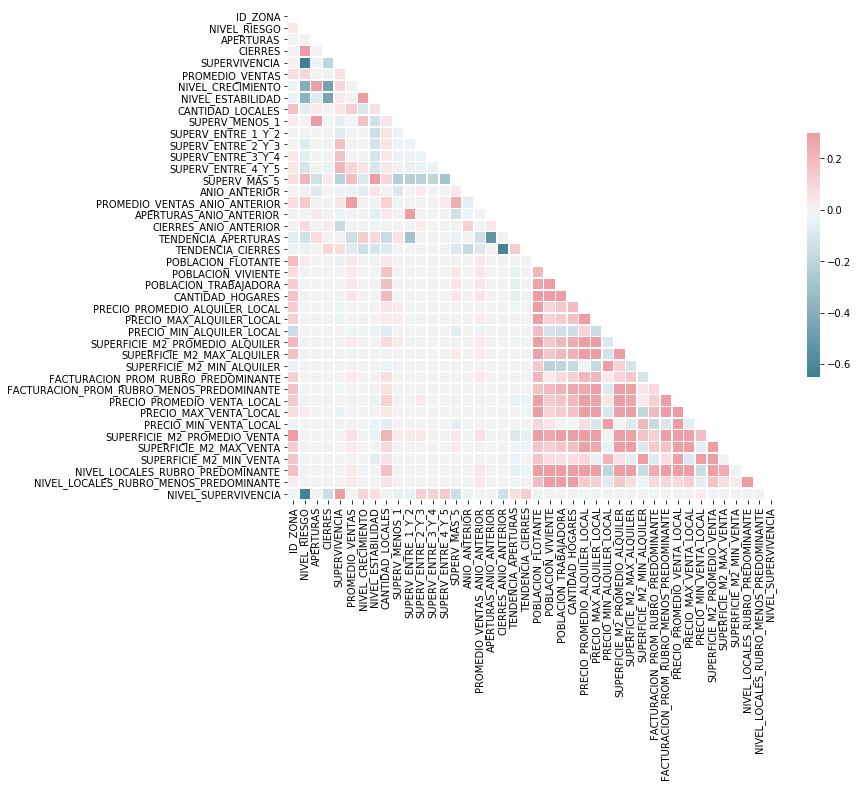

In [286]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

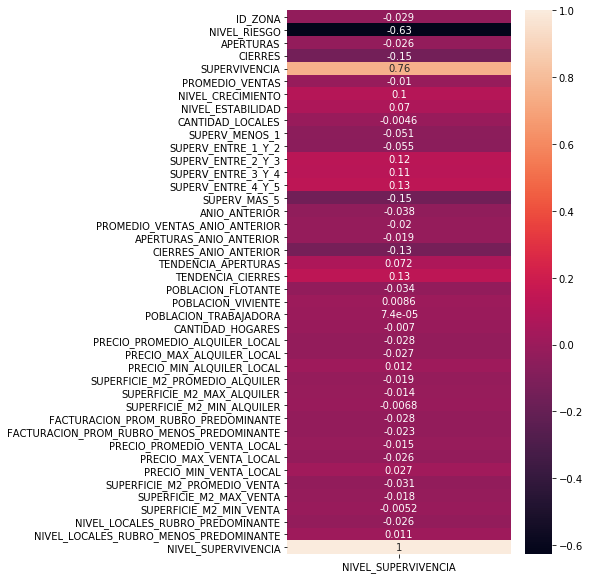

In [287]:
plt.figure(figsize=(5,10))
sns.heatmap(df.corr()[['NIVEL_SUPERVIVENCIA']], annot=True)

In [288]:
df.drop(columns=['NIVEL_RIESGO',
                'SUPERVIVENCIA',
                'ANIO_ANTERIOR',
                'PROMEDIO_VENTAS_ANIO_ANTERIOR',
                'APERTURAS_ANIO_ANTERIOR',
                'CIERRES_ANIO_ANTERIOR',
                'TENDENCIA_APERTURAS',
                'TENDENCIA_CIERRES',
                'NIVEL_ESTABILIDAD',
                'NIVEL_CRECIMIENTO',
                'SUPERV_MENOS_1',
                'SUPERV_ENTRE_1_Y_2',
                'SUPERV_ENTRE_2_Y_3',
                'SUPERV_ENTRE_3_Y_4',
                'SUPERV_ENTRE_4_Y_5',
                'SUPERV_MAS_5'
                ], axis=1, inplace=True)

In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26082 entries, 0 to 26081
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ID_ZONA                                    26082 non-null  int64  
 1   RUBRO                                      26082 non-null  object 
 2   APERTURAS                                  26082 non-null  float64
 3   CIERRES                                    26082 non-null  float64
 4   PROMEDIO_VENTAS                            26082 non-null  int64  
 5   CANTIDAD_LOCALES                           26082 non-null  int64  
 6   POBLACION_FLOTANTE                         25920 non-null  float64
 7   POBLACION_VIVIENTE                         25920 non-null  float64
 8   POBLACION_TRABAJADORA                      25920 non-null  float64
 9   CANTIDAD_HOGARES                           25920 non-null  float64
 10  PRECIO_PROMEDIO_ALQUIL

In [290]:
df['ID_ZONA'] = df['ID_ZONA'].astype(str)

In [291]:
df.dropna(inplace=True, axis=0)

In [292]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20038 entries, 20 to 26063
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ID_ZONA                                    20038 non-null  object 
 1   RUBRO                                      20038 non-null  object 
 2   APERTURAS                                  20038 non-null  float64
 3   CIERRES                                    20038 non-null  float64
 4   PROMEDIO_VENTAS                            20038 non-null  int64  
 5   CANTIDAD_LOCALES                           20038 non-null  int64  
 6   POBLACION_FLOTANTE                         20038 non-null  float64
 7   POBLACION_VIVIENTE                         20038 non-null  float64
 8   POBLACION_TRABAJADORA                      20038 non-null  float64
 9   CANTIDAD_HOGARES                           20038 non-null  float64
 10  PRECIO_PROMEDIO_ALQUI

In [293]:
df['NIVEL_SUPERVIVENCIA'].value_counts()

0.0    10191
1.0     9847
Name: NIVEL_SUPERVIVENCIA, dtype: int64

In [294]:
df['NS'] = df['NIVEL_SUPERVIVENCIA'].astype(str)

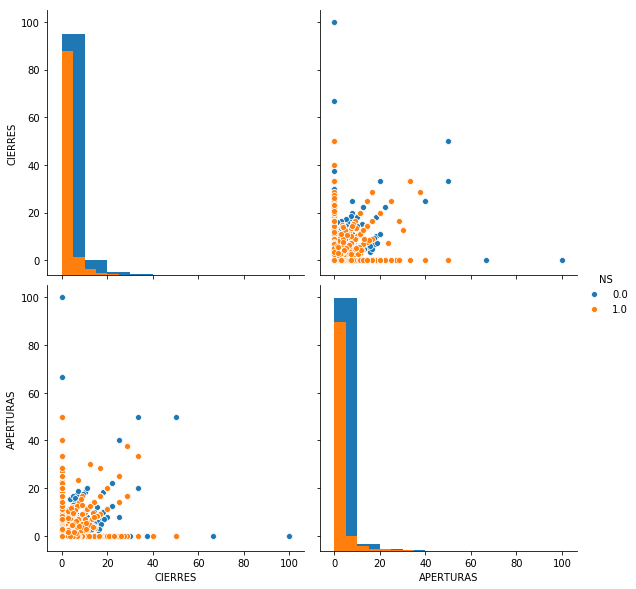

In [295]:
sns.pairplot(data=df[['CIERRES', 'APERTURAS', 'NS']], 
             vars=['CIERRES', 'APERTURAS'], 
             hue='NS', 
             height=4, 
             diag_kind='hist');

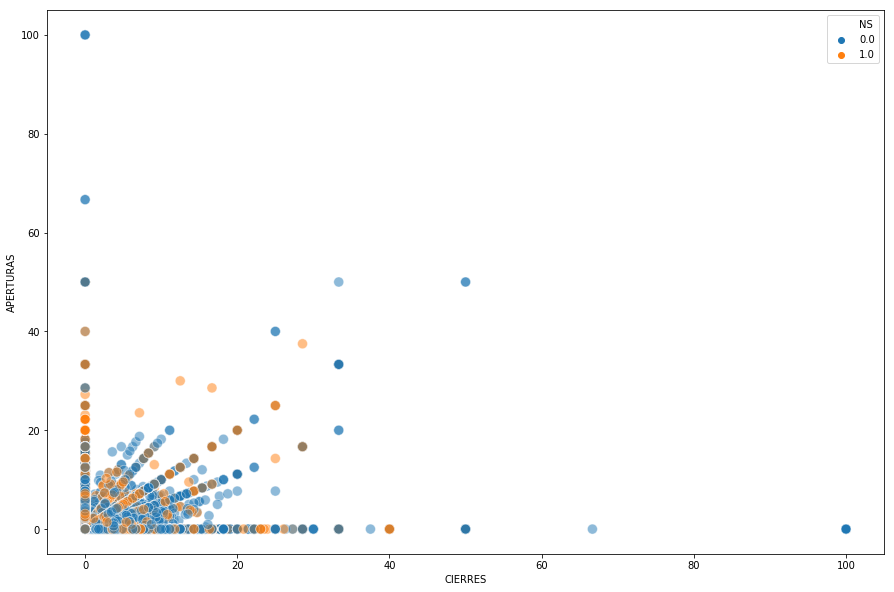

In [296]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=df, x=df['CIERRES'], y=df['APERTURAS'], hue='NS', alpha=0.5, sizes=(40, 400), s=100)

In [297]:
df['ID_ZONA'].value_counts().unique()

array([162, 161, 160, 158, 157, 156, 155, 153, 152, 151, 150, 149, 148,
       147, 146, 145, 144, 143, 142, 141, 140, 138, 137, 136, 135, 134,
       133, 132, 131, 130, 129, 128, 127, 126, 125, 123, 122, 121, 120,
       119, 118, 115, 112, 111, 109, 107, 105, 104,  99,  98,  94,  93,
        91,  83,  76,  73,  45,  33,  24,   2], dtype=int64)

In [298]:
df['RUBRO'].value_counts().unique()

array([1333, 1324, 1301, 1296, 1291, 1287, 1281, 1228, 1216, 1206, 1182,
       1157, 1002,  989,  976,  896,  600,  473], dtype=int64)

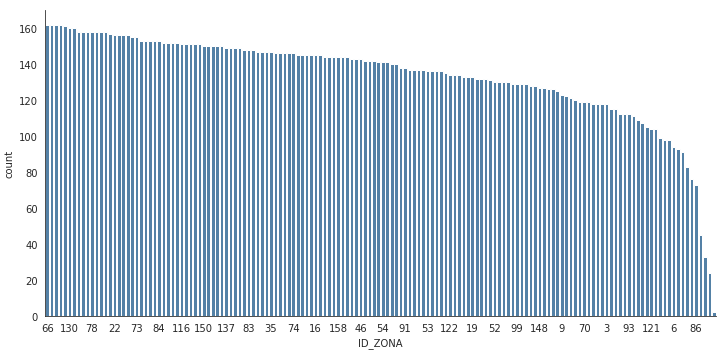

In [299]:
with sns.axes_style('white'):
    g = sns.catplot("ID_ZONA", data=df, aspect=2, kind="count", color='steelblue', order = df['ID_ZONA'].value_counts().index)
    g.set_xticklabels(step=5)

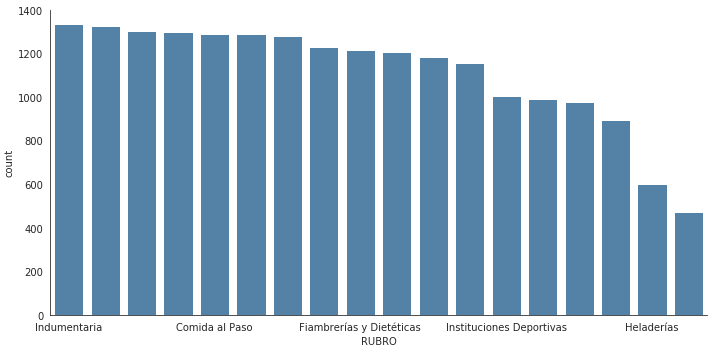

In [300]:
with sns.axes_style('white'):
    g = sns.catplot("RUBRO", data=df, aspect=2, kind="count", color='steelblue', order = df['RUBRO'].value_counts().index)
    g.set_xticklabels(step=4)

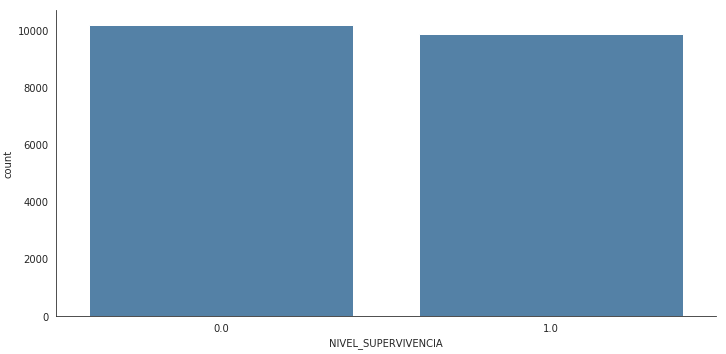

In [301]:
with sns.axes_style('white'):
    g = sns.catplot("NIVEL_SUPERVIVENCIA", data=df, aspect=2, kind="count", color='steelblue', order = df['NIVEL_SUPERVIVENCIA'].value_counts().index)
    g.set_xticklabels(step=1)

---
---
<b><a id='section_2'><h4>2. Dataset final</h4></a></b>

In [302]:
predecir = ['NIVEL_SUPERVIVENCIA']
features = ['ID_ZONA', 'RUBRO', 'APERTURAS', 'CIERRES',
       'PROMEDIO_VENTAS', 'CANTIDAD_LOCALES', 'POBLACION_FLOTANTE',
       'POBLACION_VIVIENTE', 'POBLACION_TRABAJADORA', 'CANTIDAD_HOGARES',
       'PRECIO_PROMEDIO_ALQUILER_LOCAL', 'PRECIO_MAX_ALQUILER_LOCAL',
       'PRECIO_MIN_ALQUILER_LOCAL', 'SUPERFICIE_M2_PROMEDIO_ALQUILER',
       'SUPERFICIE_M2_MAX_ALQUILER', 'SUPERFICIE_M2_MIN_ALQUILER',
       'RUBRO_PREDOMINANTE', 'FACTURACION_PROM_RUBRO_PREDOMINANTE',
       'FACTURACION_PROM_RUBRO_MENOS_PREDOMINANTE',
       'RUBRO_MENOS_PREDOMINANTE', 'PRECIO_PROMEDIO_VENTA_LOCAL',
       'PRECIO_MAX_VENTA_LOCAL', 'PRECIO_MIN_VENTA_LOCAL',
       'SUPERFICIE_M2_PROMEDIO_VENTA', 'SUPERFICIE_M2_MAX_VENTA',
       'SUPERFICIE_M2_MIN_VENTA', 'NIVEL_LOCALES_RUBRO_PREDOMINANTE',
       'NIVEL_LOCALES_RUBRO_MENOS_PREDOMINANTE']

In [451]:
variables = ['ID_ZONA', 'RUBRO', 'APERTURAS', 'CIERRES',
       'PROMEDIO_VENTAS', 'CANTIDAD_LOCALES', 'POBLACION_FLOTANTE',
       'POBLACION_VIVIENTE', 'POBLACION_TRABAJADORA', 'CANTIDAD_HOGARES',
       'PRECIO_PROMEDIO_ALQUILER_LOCAL', 'PRECIO_MAX_ALQUILER_LOCAL',
       'PRECIO_MIN_ALQUILER_LOCAL', 'SUPERFICIE_M2_PROMEDIO_ALQUILER',
       'SUPERFICIE_M2_MAX_ALQUILER', 'SUPERFICIE_M2_MIN_ALQUILER',
       'RUBRO_PREDOMINANTE', 'FACTURACION_PROM_RUBRO_PREDOMINANTE',
       'FACTURACION_PROM_RUBRO_MENOS_PREDOMINANTE',
       'RUBRO_MENOS_PREDOMINANTE', 'PRECIO_PROMEDIO_VENTA_LOCAL',
       'PRECIO_MAX_VENTA_LOCAL', 'PRECIO_MIN_VENTA_LOCAL',
       'SUPERFICIE_M2_PROMEDIO_VENTA', 'SUPERFICIE_M2_MAX_VENTA',
       'SUPERFICIE_M2_MIN_VENTA', 'NIVEL_LOCALES_RUBRO_PREDOMINANTE',
       'NIVEL_LOCALES_RUBRO_MENOS_PREDOMINANTE', 'NIVEL_SUPERVIVENCIA']

vars_pairplot0 = ['APERTURAS', 'CIERRES', 'POBLACION_VIVIENTE', 'CANTIDAD_HOGARES']
vars_pairplot0A = ['APERTURAS', 'POBLACION_VIVIENTE']
vars_pairplot0B = ['CIERRES', 'POBLACION_VIVIENTE']

vars_pairplot1 = ['APERTURAS', 'CIERRES',
       'PROMEDIO_VENTAS', 'CANTIDAD_LOCALES', 'POBLACION_FLOTANTE',
       'POBLACION_VIVIENTE', 'POBLACION_TRABAJADORA', 'CANTIDAD_HOGARES']
                  
vars_pairplot2 = ['PRECIO_PROMEDIO_ALQUILER_LOCAL', 'PRECIO_MAX_ALQUILER_LOCAL',
       'PRECIO_MIN_ALQUILER_LOCAL', 
       'PRECIO_PROMEDIO_VENTA_LOCAL',
       'PRECIO_MAX_VENTA_LOCAL', 'PRECIO_MIN_VENTA_LOCAL']

vars_pairplot3 = ['SUPERFICIE_M2_PROMEDIO_ALQUILER',
       'SUPERFICIE_M2_MAX_ALQUILER', 'SUPERFICIE_M2_MIN_ALQUILER',
       'SUPERFICIE_M2_PROMEDIO_VENTA', 'SUPERFICIE_M2_MAX_VENTA',
       'SUPERFICIE_M2_MIN_VENTA', 'NIVEL_LOCALES_RUBRO_PREDOMINANTE',
       'NIVEL_LOCALES_RUBRO_MENOS_PREDOMINANTE', 'NIVEL_SUPERVIVENCIA']

vars_pairplot4 = ['FACTURACION_PROM_RUBRO_PREDOMINANTE',
       'FACTURACION_PROM_RUBRO_MENOS_PREDOMINANTE']

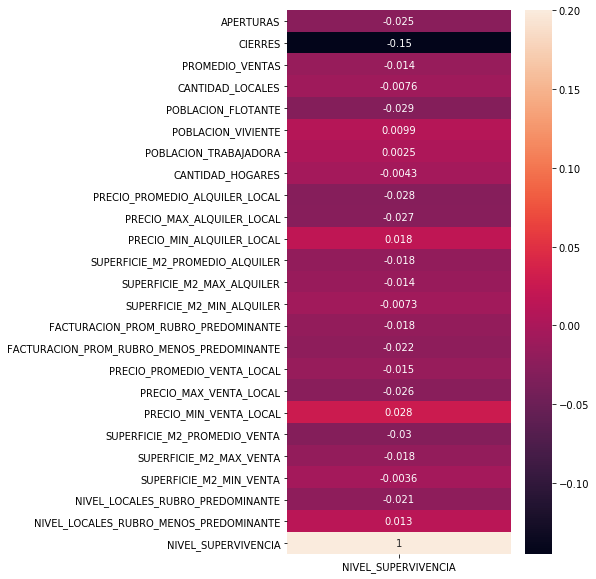

In [304]:
plt.figure(figsize=(5,10))
sns.heatmap(df[variables].corr()[['NIVEL_SUPERVIVENCIA']], annot=True, vmax=.2)

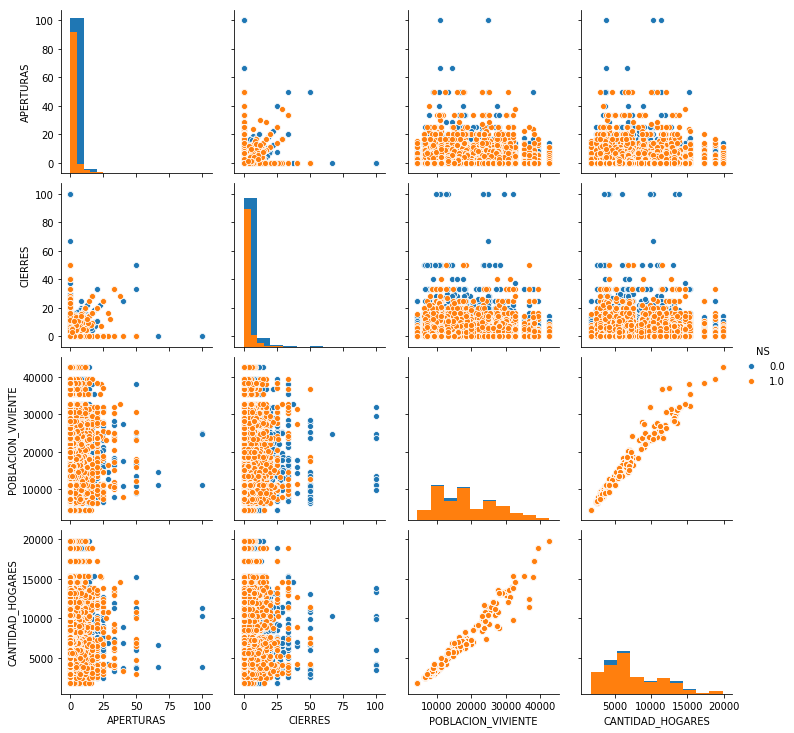

In [441]:
sns.pairplot(data=df, vars=vars_pairplot0, height=2.5, hue='NS', diag_kind='hist');

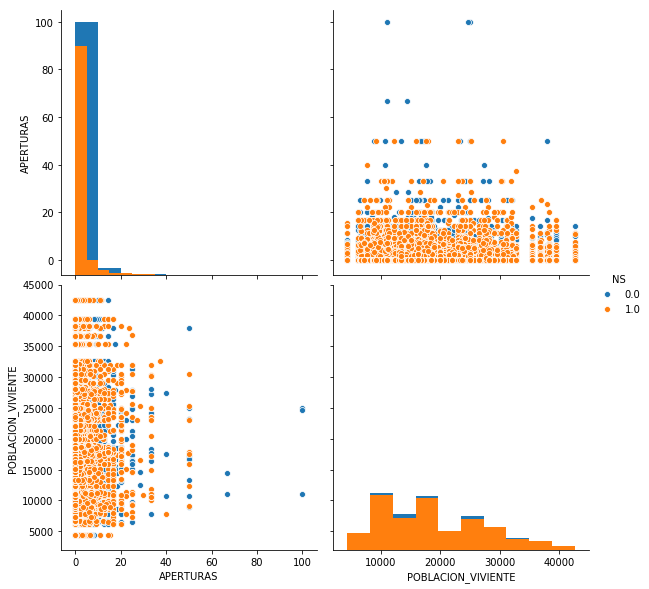

In [446]:
sns.pairplot(data=df, vars=vars_pairplot0A, height=4, hue='NS', diag_kind='hist');

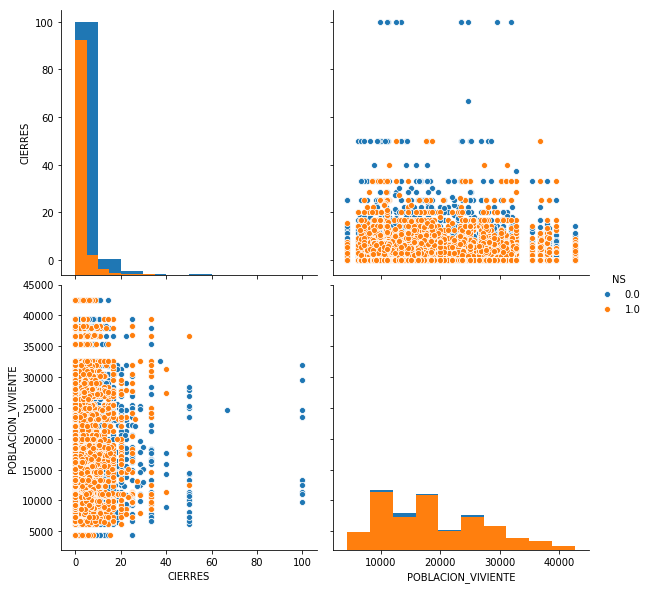

In [450]:
sns.pairplot(data=df, vars=vars_pairplot0B, height=4, hue='NS', diag_kind='hist');

In [469]:
grupo_zonas = df[['ID_ZONA', 'CIERRES']].groupby(by=['ID_ZONA']).agg({'CIERRES': ['max']}).reset_index().sort_values(by=[('CIERRES', 'max')], ascending=False)


In [474]:
grupo_zonas.head(10)

,ID_ZONA,CIERRES
,,max
61,157,100.0
7,106,100.0
117,68,100.0
135,86,100.0
92,44,100.0
8,107,100.0
11,11,100.0
6,105,100.0
145,95,100.0


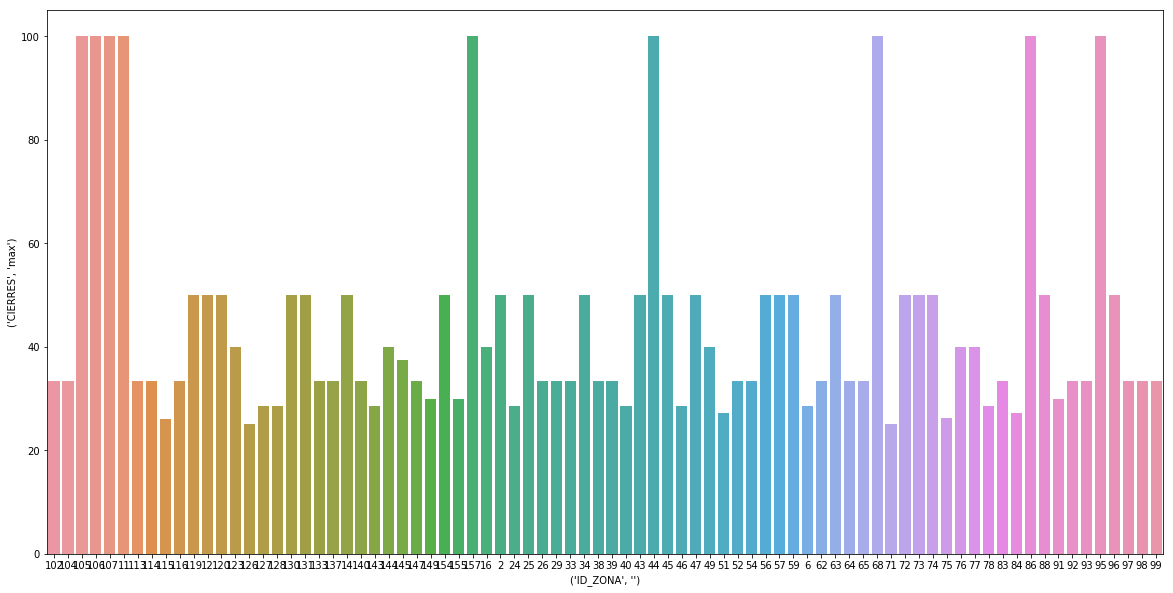

In [479]:
plt.figure(figsize=(20,10))
sns.barplot(x=('ID_ZONA', ''), y=('CIERRES', 'max'), data=grupo_zonas.head(80))

In [305]:
# Creamos dummies
df_final = pd.get_dummies(df[features], columns=['ID_ZONA', 
                                                 'RUBRO', 
                                                 'RUBRO_PREDOMINANTE', 
                                                 'RUBRO_MENOS_PREDOMINANTE',
                                                 'FACTURACION_PROM_RUBRO_PREDOMINANTE',
                                                 'FACTURACION_PROM_RUBRO_MENOS_PREDOMINANTE',
                                                 'NIVEL_LOCALES_RUBRO_PREDOMINANTE', 
                                                 'NIVEL_LOCALES_RUBRO_MENOS_PREDOMINANTE'], drop_first=True)

In [306]:
X = df_final
y = df[predecir]

In [307]:
df['ID_ZONA'].value_counts()

66     162
60     162
27     162
95     162
118    161
      ... 
86      73
14      45
2       33
5       24
8        2
Name: ID_ZONA, Length: 150, dtype: int64

In [308]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 0)

In [309]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [310]:
df_results = pd.DataFrame(columns=['Metodo','accuracy_train','accuracy_test'])

In [311]:
def setResults(data,metodo,accuracy_train,accuracy_test):
    data.loc[-1] = [metodo,accuracy_train,accuracy_test]
    data.index = data.index + 1  # shifting index
    data = data.sort_index() 

---
---
<b><a id='section_3'><h4>3. Modelos implementados</h4></a></b>
<a href='#section_3_1'>3.1. Regresión logística</a>  
<a href='#section_3_2'>3.2. KNeighborsClassifier</a>  

<b><a id='section_3_1'>3.1. Regresión logística</a>  </b>

In [312]:
logistic_regression = LogisticRegression()

In [313]:
logistic_regression.fit(X_train_std, y_train.values.reshape(-1))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [314]:
y_pred_test = logistic_regression.predict(X_test_std)

In [315]:
lr_accuracy_test = accuracy_score(y_test, y_pred_test)
lr_accuracy_test

0.6425149700598802

In [316]:
y_pred_train = logistic_regression.predict(X_train_std)
lr_accuracy_train = accuracy_score(y_train, y_pred_train)
lr_accuracy_train

0.6593691775352675

In [317]:
setResults(df_results, 'LR-Default',lr_accuracy_train,lr_accuracy_test)


In [318]:
y_test['NIVEL_SUPERVIVENCIA'].value_counts()

0.0    2548
1.0    2462
Name: NIVEL_SUPERVIVENCIA, dtype: int64

Text(33,0.5,'Reales')

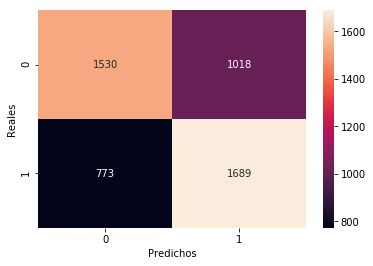

In [319]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='.0f')
plt.xlabel('Predichos')
plt.ylabel('Reales')

In [320]:
y_pred_proba_logit = logistic_regression.predict_proba(X_test_std)

In [321]:
y_pred_proba_logit.shape

(5010, 2)

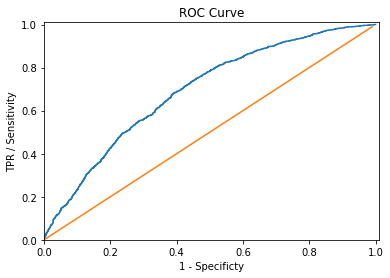

AUC:  0.6914774908276127


In [322]:
curva_roc_y_auc(y_pred_proba_logit)

In [323]:
from sklearn.metrics import precision_score, recall_score
print('Accuracy=', accuracy_score(y_test, y_pred_test))
print('Recall=', recall_score(y_test, y_pred_test))
print('Precision=', precision_score(y_test, y_pred_test))

Accuracy= 0.6425149700598802
Recall= 0.6860276198212835
Precision= 0.6239379386775028


In [324]:
from sklearn.preprocessing import binarize
y_pred_logit = binarize(y_pred_proba_logit, 0.6)[:,1]

Text(33,0.5,'Reales')

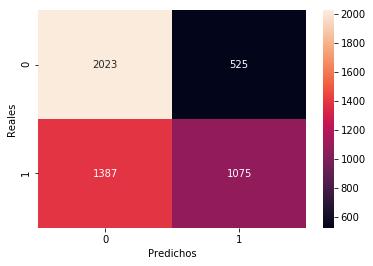

In [325]:
sns.heatmap(confusion_matrix(y_test, y_pred_logit, ), annot=True, fmt='.0f')
plt.xlabel('Predichos')
plt.ylabel('Reales')

<b><a id='section_3_2'>3.2. KNeighborsClassifier</a>  </b>

In [326]:
def scores_knn(X, y, start, stop, step):
    
    # Vamos a querer graficar los distintos valores del score de cross validation en función del hiperparámetro n_neighbors
    # Para esto vamos a generar una lista de diccionarios que después se puede convertir fácilmente en DataFrame
    
    # Lista de diccionarios - la inicializamos vacío y por fuera del for loop para ir alimentándola en cada iteración
    scores_para_df = []
    
    
    for i in range(start,stop,step):
        
        # En cada iteración, instanciamos el modelo con un hiperparámetro distinto
        model = KNeighborsClassifier(n_neighbors=i)

        # cross_val_scores nos devuelve un array de 5 resultados, uno por cada partición que hizo automáticamente CV
        kf = KFold(n_splits=3, shuffle=True, random_state=10)
        cv_scores = cross_val_score(model, X, y, cv=kf)

        # Para cada valor de n_neighbours, creamos un diccionario con el valor de n_neighbours y la media y el desvío de los scores
        dict_row_score = {'score_medio':np.mean(cv_scores),'score_std':np.std(cv_scores),'n_neighbours':i}

        # Guardamos cada uno en la lista de diccionarios
        scores_para_df.append(dict_row_score)
    
    # Creamos el DF a partir de la lista de resultados
    df_scores = pd.DataFrame(scores_para_df)
    
    # Incorporamos los límites inferior y superior, restando y sumando el valor del desvío estándar, respectivamente
    df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
    df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']
    
    # Retornamos el DF
    return df_scores

In [327]:
df_scores_1= scores_knn(X_train_std, y_train.values.reshape(-1), 2, 10, 1)

In [328]:
df_scores_1

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
0,0.740019,0.005070,2,0.734949,0.745089
1,0.738821,0.002442,3,0.736379,0.741262
2,0.722851,0.004119,4,0.718732,0.726970
3,0.720522,0.003929,5,0.716593,0.724451
4,0.700493,0.004131,6,0.696362,0.704624
5,0.697365,0.005477,7,0.691889,0.702842
6,0.678999,0.003017,8,0.675983,0.682016
7,0.677669,0.004763,9,0.672906,0.682432


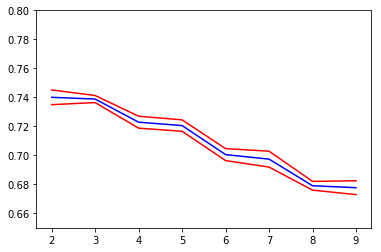

In [329]:
plt.plot(df_scores_1['n_neighbours'], df_scores_1['limite_inferior'], color='r')
plt.plot(df_scores_1['n_neighbours'], df_scores_1['score_medio'], color='b')
plt.plot(df_scores_1['n_neighbours'], df_scores_1['limite_superior'], color='r')
plt.ylim(0.65, 0.8);

In [330]:
df_scores_1.loc[df_scores_1.score_medio == df_scores_1.score_medio.max()]

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
0,0.740019,0.00507,2,0.734949,0.745089


In [331]:
best_k_1 = df_scores_1.loc[df_scores_1.score_medio == df_scores_1.score_medio.max(),'n_neighbours'].values[0]
best_k_1

2

In [332]:
model_knn_1 = KNeighborsClassifier(n_neighbors=best_k_1)
model_knn_1.fit(X_train_std, y_train.values.reshape(-1))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [333]:
knn1_accuracy_train = accuracy_score(y_train, model_knn_1.predict(X_train_std))
knn1_accuracy_train

0.8753659834974714

In [334]:
y_pred_knn_1 = model_knn_1.predict(X_test_std)

In [335]:
knn1_accuracy_test = accuracy_score(y_test, y_pred_knn_1)
knn1_accuracy_test

0.7588822355289421

In [336]:
setResults(df_results, 'KNN_neighbors%s' % (best_k_1),knn1_accuracy_train,knn1_accuracy_test)


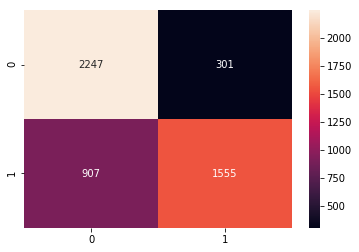

In [337]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_knn_1), annot=True, fmt='.0f')

In [338]:
y_pred_proba_knn_1 = model_knn_1.predict_proba(X_test_std)

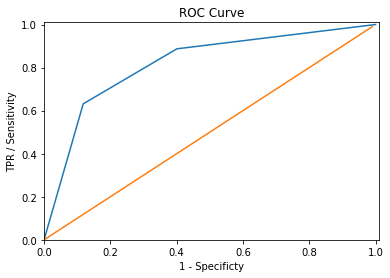

AUC:  0.817335349749473


In [339]:
curva_roc_y_auc(y_pred_proba_knn_1)

In [340]:
print('Accuracy=', accuracy_score(y_test, y_pred_knn_1))
print('Recall=', recall_score(y_test, y_pred_knn_1))
print('Precision=', precision_score(y_test, y_pred_knn_1))

Accuracy= 0.7588822355289421
Recall= 0.6316003249390739
Precision= 0.837823275862069


---
---
<b><a id='section_4'><h4>4. Modelos + reducción de dimensionalidad</h4></a></b>
<a href='#section_4_1'>4.1. PCA + KNClassifier</a>  
<a href='#section_4_2'>4.2. PCA + NaiveBayes</a>  
<a href='#section_4_3'>4.3. PCA + Regresión Logística</a> 


<b><a id='section_4_1'>4.1. PCA + KNClassifier</a>  </b>

In [341]:
#Veamos si mejora el score reduciendo dimensionalidad

In [342]:
def plot_explained_variance(components_count, X):

    model_pca = PCA(components_count).fit(X)

    explained_variance = model_pca.explained_variance_ratio_

    #print(explained_variance)

    cumulative_explained_variance = np.cumsum(explained_variance)

    #print(cumulative_explained_variance)

    plt.plot(cumulative_explained_variance)
    plt.xlabel('número de componentes')
    plt.ylabel('% de varianza explicada');

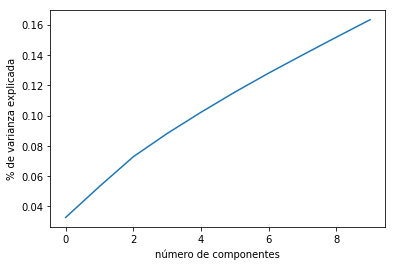

In [343]:
plot_explained_variance(components_count = 10, X = X_train_std)

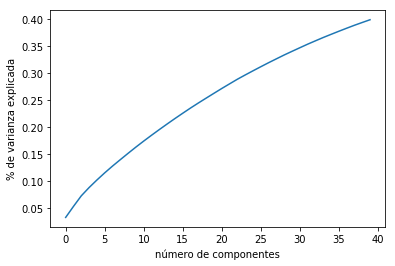

In [344]:
plot_explained_variance(components_count = 40, X = X_train_std)

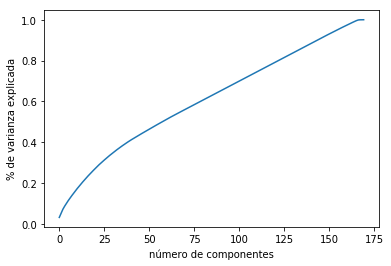

In [345]:
plot_explained_variance(components_count = 170, X = X_train_std)

In [346]:
model_pca = PCA(170).fit(X_train_std)
X_train_PCA = model_pca.transform(X_train_std)
X_test_PCA = model_pca.transform(X_test_std)

In [347]:
df_scores_2 = scores_knn(X_train_PCA, y_train.values.reshape(-1), 2, 5, 1)

In [348]:
df_scores_2

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
0,0.738488,0.005352,2,0.733136,0.743840
1,0.737756,0.002045,3,0.735712,0.739801
2,0.723583,0.004542,4,0.719041,0.728125


In [349]:
df_scores_2.loc[df_scores_2.score_medio == df_scores_2.score_medio.max()]

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
0,0.738488,0.005352,2,0.733136,0.74384


In [350]:
best_k_2 = df_scores_2.loc[df_scores_2.score_medio == df_scores_2.score_medio.max(),'n_neighbours'].values[0]
best_k_2

2

In [351]:
model_knn_2 = KNeighborsClassifier(n_neighbors=best_k_2)
model_knn_2.fit(X_train_PCA, y_train.values.reshape(-1))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [352]:
accuracy_knnpca_train = accuracy_score(y_train, model_knn_2.predict(X_train_PCA))
accuracy_knnpca_train

0.8750332712270429

In [353]:
y_pred_knn_2 = model_knn_2.predict(X_test_PCA)

In [354]:
accuracy_knnpca_test = accuracy_score(y_test, y_pred_knn_2)
accuracy_knnpca_test

0.756686626746507

In [355]:
setResults(df_results, 'KNN_PCA_neighbors%s' % (best_k_2),accuracy_knnpca_train,accuracy_knnpca_test)


In [356]:
y_pred_train_knn_2 = model_knn_2.predict(X_train_PCA)

In [484]:
from sklearn.metrics import f1_score
f1_score(y_train, model_knn_2.predict(X_train_PCA))

0.8552712700369913

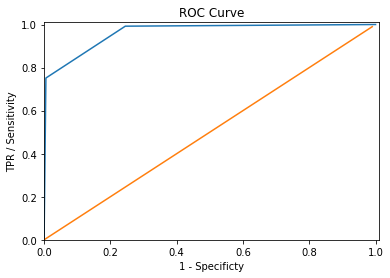

AUC:  0.9629518817516012


In [357]:
curva_roc_y_auc_otro(model_knn_2.predict_proba(X_train_PCA), y_train)

In [358]:
print('Accuracy=', accuracy_score(y_train, y_pred_train_knn_2))
print('Recall=', recall_score(y_train, y_pred_train_knn_2))
print('Precision=', precision_score(y_train, y_pred_train_knn_2))

Accuracy= 0.8750332712270429
Recall= 0.7513879485443467
Precision= 0.9924879270255769


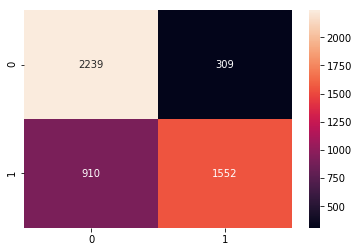

In [359]:
sns.heatmap(confusion_matrix(y_test, y_pred_knn_2), annot=True, fmt='.0f')

In [360]:
y_pred_proba_knn_2 = model_knn_2.predict_proba(X_test_PCA)

In [485]:
from sklearn.metrics import f1_score
f1_score(y_test, model_knn_2.predict(X_test_PCA))

0.7180198935924127

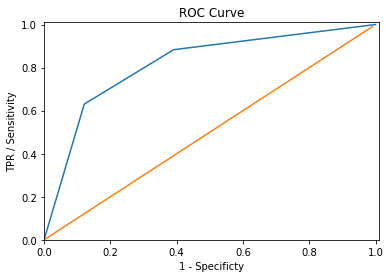

AUC:  0.8157273126084776


In [361]:
curva_roc_y_auc(y_pred_proba_knn_2)

In [362]:
print('Accuracy=', accuracy_score(y_test, y_pred_knn_2))
print('Recall=', recall_score(y_test, y_pred_knn_2))
print('Precision=', precision_score(y_test, y_pred_knn_2))

Accuracy= 0.756686626746507
Recall= 0.6303818034118602
Precision= 0.8339602364320258


<b><a id='section_4_2'>4.2. PCA + NaiveBayes</a>  </b>

In [363]:
gnb_1 = GaussianNB()
gnb_1.fit(X_train_std, y_train.values.reshape(-1))

GaussianNB(priors=None, var_smoothing=1e-09)

In [364]:
y_pred_nb_train_1 = gnb_1.predict(X_train_std)

In [365]:
accuracy_g_train = accuracy_score(y_train, y_pred_nb_train_1)
accuracy_g_train

0.5801836571732766

In [366]:
y_pred_nb_1 = gnb_1.predict(X_test_std)

In [367]:
accuracy_g_test = accuracy_score(y_test, y_pred_nb_1)
accuracy_g_test

0.5654690618762475

In [368]:
setResults(df_results, 'GNB',accuracy_g_train,accuracy_g_test)

In [369]:
y_pred_proba_nb_1 = gnb_1.predict_proba(X_test_std)

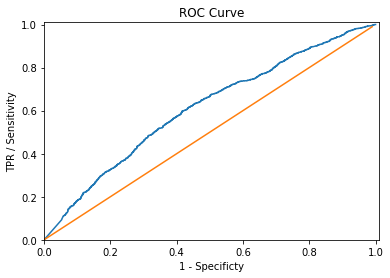

AUC:  0.6101984066762992


In [370]:
curva_roc_y_auc(y_pred_proba_nb_1)

In [371]:
print('Accuracy=', accuracy_score(y_test, y_pred_nb_1))
print('Recall=', recall_score(y_test, y_pred_nb_1))
print('Precision=', precision_score(y_test, y_pred_nb_1))

Accuracy= 0.5654690618762475
Recall= 0.2859463850528026
Precision= 0.6268922528940338


In [372]:
gnb_2 = GaussianNB()
gnb_2.fit(X_train_PCA, y_train.values.reshape(-1))

GaussianNB(priors=None, var_smoothing=1e-09)

In [373]:
y_pred_nb_train_2 = gnb_2.predict(X_train_PCA)

In [374]:
accuracy_GNB_PCA_train = accuracy_score(y_train, y_pred_nb_train_2)
accuracy_GNB_PCA_train

0.5535666755389939

In [375]:
print('Accuracy=', accuracy_score(y_train, y_pred_nb_train_2))
print('Recall=', recall_score(y_train, y_pred_nb_train_2))
print('Precision=', precision_score(y_train, y_pred_nb_train_2))

Accuracy= 0.5535666755389939
Recall= 0.39187542315504403
Precision= 0.5661189358372457


In [480]:
from sklearn.metrics import f1_score
f1_score(y_train, y_pred_nb_train_2)

0.46315115627750664

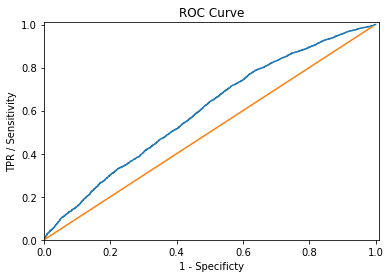

AUC:  0.5971526509979749


In [376]:
curva_roc_y_auc_otro(gnb_2.predict_proba(X_train_PCA), y_train)

In [377]:
y_pred_nb_2 = gnb_2.predict(X_test_PCA)

In [378]:
accuracy_GNB_PCA_test = accuracy_score(y_test, y_pred_nb_2)
accuracy_GNB_PCA_test

0.5497005988023952

In [481]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_nb_2)

0.4799446749654218

In [379]:
setResults(df_results, 'NB',accuracy_GNB_PCA_train,accuracy_GNB_PCA_test)

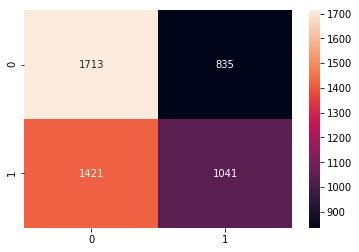

In [380]:
sns.heatmap(confusion_matrix(y_test, y_pred_nb_2), annot=True, fmt='.0f')

In [381]:
y_pred_proba_nb_2 = gnb_2.predict_proba(X_test_PCA)

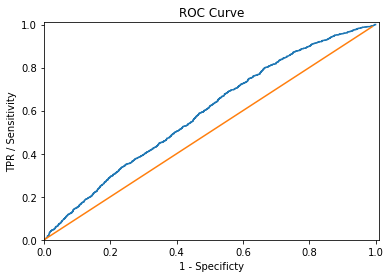

AUC:  0.5879912344241577


In [382]:
curva_roc_y_auc(y_pred_proba_nb_2)

In [383]:
print('Accuracy=', accuracy_score(y_test, y_pred_nb_2))
print('Recall=', recall_score(y_test, y_pred_nb_2))
print('Precision=', precision_score(y_test, y_pred_nb_2))

Accuracy= 0.5497005988023952
Recall= 0.4228269699431357
Precision= 0.5549040511727079


<b><a id='section_4_3'><h4>4.3. PCA + Regresión Logística</h4></a></b>

Best parameter (CV score=0.634):
{'logistic__C': 0.0001, 'logistic__penalty': 'l2', 'logistic__solver': 'liblinear', 'pca__n_components': 170}


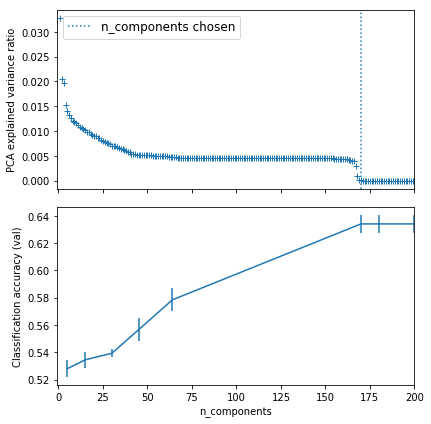

In [384]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca_2 = PCA()
# set the tolerance to a large value to make the example faster
logistic_3 = LogisticRegression(max_iter=10000, tol=0.1)
pipe_1 = Pipeline(steps=[('pca', pca_2), ('logistic', logistic_3)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid_1 = {
    'pca__n_components': [5, 15, 30, 45, 64, 170, 180, 200],
    'logistic__C': np.logspace(-4, 6, 1),
    'logistic__penalty': ['l1', 'l2'],
     'logistic__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_3 = GridSearchCV(pipe_1, param_grid_1, n_jobs=-1)
grid_3.fit(X_train_std, y_train.values.reshape(-1))
print("Best parameter (CV score=%0.3f):" % grid_3.best_score_)
print(grid_3.best_params_)
accuracy_LR_PCA_train = grid_3.best_score_
method = 'LR_solver:%s_C:%s_pen:%s_PCA:%s'% (grid_3.best_params_['logistic__solver'], grid_3.best_params_['logistic__C'],grid_3.best_params_['logistic__penalty'],grid_3.best_params_['pca__n_components'])
# Plot the PCA spectrum
pca_2.fit(X_train_std)

fig, (ax0, ax1) =  plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca_2.n_components_ + 1),
         pca_2.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(grid_3.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(grid_3.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 200)

plt.tight_layout()
plt.show()

In [385]:
y_pred_train_grid_3 = grid_3.predict(X_train_std)

In [482]:
from sklearn.metrics import f1_score
f1_score(y_train, y_pred_train_grid_3)

0.6565035331065167

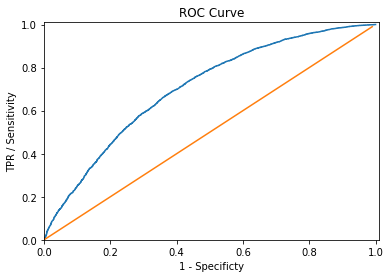

AUC:  0.7029665743059592


In [386]:
curva_roc_y_auc_otro(grid_3.predict_proba(X_train_std), y_train)

In [387]:
print('Accuracy=', accuracy_score(y_train, y_pred_train_grid_3))
print('Recall=', recall_score(y_train, y_pred_train_grid_3))
print('Precision=', precision_score(y_train, y_pred_train_grid_3))

Accuracy= 0.6506521160500399
Recall= 0.6793500338524036
Precision= 0.6351436890745664


In [388]:
y_pred_grid_3 = grid_3.predict(X_test_std)

In [389]:
accuracy_LR_PCA_test = accuracy_score(y_test, y_pred_grid_3)
accuracy_LR_PCA_test

0.6305389221556886

In [483]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_grid_3)

0.6386882685926215

In [390]:
setResults(df_results, method,accuracy_LR_PCA_train,accuracy_LR_PCA_test)

In [391]:
print (classification_report(y_test, y_pred_grid_3))

              precision    recall  f1-score   support

         0.0       0.65      0.60      0.62      2548
         1.0       0.61      0.66      0.64      2462

    accuracy                           0.63      5010
   macro avg       0.63      0.63      0.63      5010
weighted avg       0.63      0.63      0.63      5010



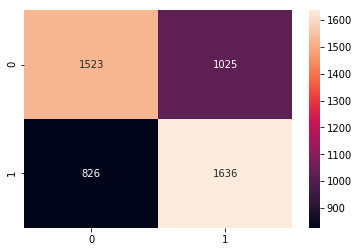

In [392]:
sns.heatmap(confusion_matrix(y_test, y_pred_grid_3), annot=True, fmt='.0f')

In [393]:
y_pred_proba_grid_3 = grid_3.predict_proba(X_test_std)

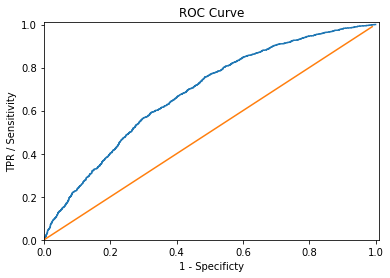

AUC:  0.6816886693438857


In [394]:
curva_roc_y_auc(y_pred_proba_grid_3)

In [395]:
print('Accuracy=', accuracy_score(y_test, y_pred_grid_3))
print('Recall=', recall_score(y_test, y_pred_grid_3))
print('Precision=', precision_score(y_test, y_pred_grid_3))

Accuracy= 0.6305389221556886
Recall= 0.6645004061738424
Precision= 0.6148064637354378


---
---
<b><a id='section_5'><h4>5. Modelos + Grid search</h4></a></b>

In [396]:
# penalty L1: Lasso y L2: Ridge
params_2 = [
    {'C': np.logspace(-4, 6, 1),
     'penalty': ['l1', 'l2'],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
]
folds_2 = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
grid_2 = GridSearchCV(LogisticRegression( ), param_grid=params_2[0], cv=folds_2, n_jobs=2)
grid_2.fit(X_train_std, y_train.values.reshape(-1))
display(grid_2.best_estimator_, grid_2.best_score_, grid_2.best_params_)
accuracy_LR_train = grid_2.best_score_
method = 'LR_solver:%s_C:%s_pen:%s'% (grid_3.best_params_['logistic__solver'], grid_3.best_params_['logistic__C'],grid_3.best_params_['logistic__penalty'])

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

0.6359468085459696

{'C': 0.0001, 'penalty': 'l2', 'solver': 'liblinear'}

In [397]:
y_pred_train_grid_2 = grid_2.predict(X_train_std)

In [487]:
from sklearn.metrics import f1_score
f1_score(y_train, y_pred_train_grid_2)

0.6561518324607329

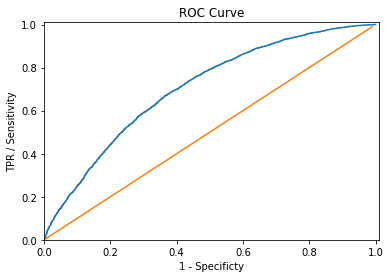

AUC:  0.702878273701931


In [398]:
curva_roc_y_auc_otro(grid_2.predict_proba(X_train_std), y_train)

In [399]:
print('Accuracy=', accuracy_score(y_train, y_pred_train_grid_2))
print('Recall=', recall_score(y_train, y_pred_train_grid_2))
print('Precision=', precision_score(y_train, y_pred_train_grid_2))

Accuracy= 0.650385946233697
Recall= 0.6788083953960731
Precision= 0.6349588347055098


In [400]:
y_pred_grid_2 = grid_2.predict(X_test_std)

In [488]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_grid_2)

0.6385636221701796

In [401]:
accuracy_LR_test = accuracy_score(y_test, y_pred_grid_2)
setResults(df_results, method,accuracy_LR_train,accuracy_LR_test)
accuracy_LR_test

0.6303393213572854

In [402]:
print (classification_report(y_test, y_pred_grid_2))

              precision    recall  f1-score   support

         0.0       0.65      0.60      0.62      2548
         1.0       0.61      0.66      0.64      2462

    accuracy                           0.63      5010
   macro avg       0.63      0.63      0.63      5010
weighted avg       0.63      0.63      0.63      5010



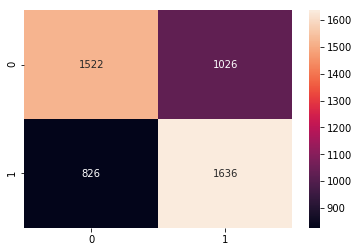

In [403]:
sns.heatmap(confusion_matrix(y_test, y_pred_grid_2), annot=True, fmt='.0f')

In [404]:
y_pred_proba_grid_2 = grid_2.predict_proba(X_test_std)

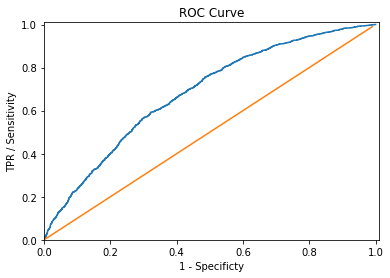

AUC:  0.6815184206532703


In [405]:
curva_roc_y_auc(y_pred_proba_grid_2)

In [406]:
print('Accuracy=', accuracy_score(y_test, y_pred_grid_2))
print('Recall=', recall_score(y_test, y_pred_grid_2))
print('Precision=', precision_score(y_test, y_pred_grid_2))

Accuracy= 0.6303393213572854
Recall= 0.6645004061738424
Precision= 0.6145755071374907


In [407]:
def accuracy_method(df):
    final_df = df.sort_values(by=['accuracy_test'], ascending=False)
    print(final_df.head(9))
    
    fig = plt.figure(figsize=(12,5))
    ax = plt.axes()
    ax.set_xticklabels(list(final_df['Metodo']))
    ax.set_xticks([0,1,2,3,4,5,6])
    plt.xlabel('Method')
    plt.ylabel('Accuracy')
    plt.title('Accuracy por método')
    plt.plot(list(final_df['accuracy_train']))
    plt.plot(list(final_df['accuracy_test']))
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.legend(['Train','test'], loc='upper right', title = "Accuracy", frameon=True)
    plt.show()
    
    
    #plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
    plt.show() 
    

                                        Metodo  accuracy_train  accuracy_test
5                               KNN_neighbors2        0.875366       0.758882
4                           KNN_PCA_neighbors2        0.875033       0.756687
6                                   LR-Default        0.659369       0.642515
1  LR_solver:liblinear_C:0.0001_pen:l2_PCA:170        0.634016       0.630539
0          LR_solver:liblinear_C:0.0001_pen:l2        0.635947       0.630339
3                                          GNB        0.580184       0.565469
2                                           NB        0.553567       0.549701


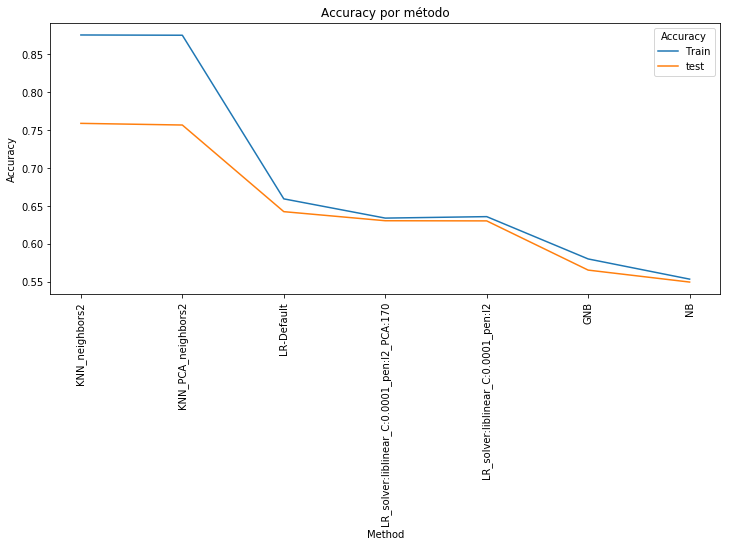

In [408]:
accuracy_method(df_results)